# Proton Recoil Telescope analysis

## Download the data

First let's download the data from the BABY-1L-run-3 available on Zenodo: https://zenodo.org/records/15177190 

In [1]:
import requests
from pathlib import Path

# Path to save the extracted files
output_file = Path("raw_2025-03-18_ROSY.h5")

if output_file.exists():
    print(f"File already exists: {output_file}")
else:
    # URL of the file
    url = "https://zenodo.org/records/15177190/files/raw_2025-03-18%20ROSY.h5?download=1"

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        # Save the file to the specified directory
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"File saved to: {output_file}")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")

File already exists: raw_2025-03-18_ROSY.h5


## Load data

To load the data, we use the ``load_data_from_file`` function in the ``prt`` module of ``libra-toolbox``.

In [2]:
from libra_toolbox.neutron_detection.diamond import prt

data = prt.load_data_from_file(output_file)

['Channel A', 'Channel B', 'Channel C', 'Channel D', 'Coincidence']
Active channels: [ True  True  True  True]
Channel 0: Channel A
Channel 1: Channel B
Channel 2: Channel C
Channel 3: Channel D


`data` is a dictionary containing, for each active channel, the timestamps in seconds and the amplitudes of the events in mV

In [3]:
data

{'Channel A': {'timestamps': array([  415.78811039,  1072.84300216,  1073.88120264, ...,
         42680.1049604 , 42680.34160139, 42680.55178646], shape=(296633,)),
  'amplitudes': array([  27.77429243,   27.26467238,  433.94146794, ..., 1119.63523789,
           31.34163274,  403.87388531], shape=(296633,))},
 'Channel B': {'timestamps': array([   44.26180857,   112.7965396 ,   137.2218714 , ...,
         42681.64475139, 42681.64734641, 42681.6553663 ], shape=(4625419,)),
  'amplitudes': array([ 31.26355419,  52.86844935,  77.77762261, ..., 237.9080221 ,
          33.04278085, 530.71789544], shape=(4625419,))},
 'Channel C': {'timestamps': array([1.12628682e+01, 4.42618085e+01, 8.61230073e+01, ...,
         4.26819807e+04, 4.26819854e+04, 4.26819877e+04], shape=(4742660,)),
  'amplitudes': array([52.92923246, 41.53298624, 30.64323984, ..., 36.72123783,
         70.65672658, 39.00048708], shape=(4742660,))},
 'Channel D': {'timestamps': array([1.49495708e+01, 3.27648884e+01, 6.77186525

In [12]:
for channel, channel_data in data.items():
    print(f"Found {len(channel_data["timestamps"])} ({len(channel_data["timestamps"]):.2e}) events in channel {channel}")

Found 296633 (2.97e+05) events in channel Channel A
Found 4625419 (4.63e+06) events in channel Channel B
Found 4742660 (4.74e+06) events in channel Channel C
Found 4496082 (4.50e+06) events in channel Channel D


Channel A contains about 10 times less counts because diamond A is thinner than diamonds B, C, and D.

## Plot data

We can now plot the amplitudes of the events (analagous to energy, but uncalibrated)

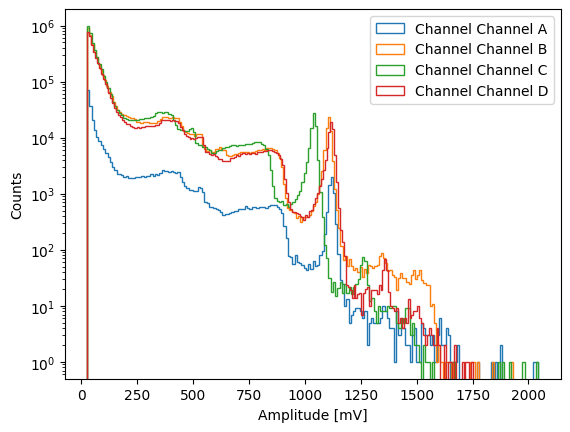

In [4]:
import matplotlib.pyplot as plt


for channel_name, channel_data in data.items():
    plt.hist(
        channel_data["amplitudes"],
        bins=200,
        histtype="step",
        label=f"Channel {channel_name}",
    )
plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.legend()
plt.show()

## Calculate count rate

With `get_count_rate` we can obtain the temporal evolution of the count rate (in count/s).

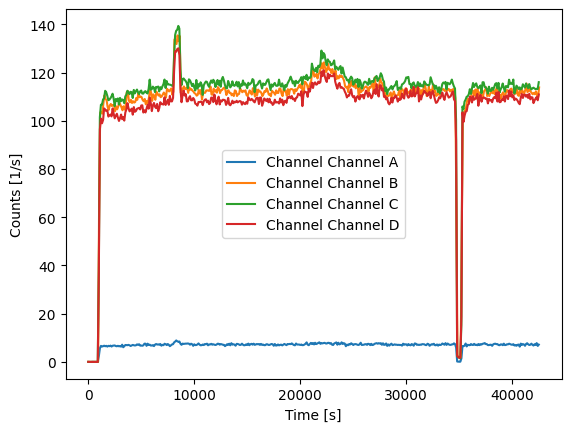

In [5]:
for channel_name, channel_data in data.items():
    count_rates, count_rate_bins = prt.get_count_rate(channel_data["timestamps"], bin_time=100)
    plt.plot(count_rate_bins[:-1], count_rates, label=f"Channel {channel_name}")

plt.xlabel("Time [s]")
plt.ylabel("Counts [1/s]")
plt.legend()
plt.show()


Increasing the `bin_time` will result in a smoother plot:

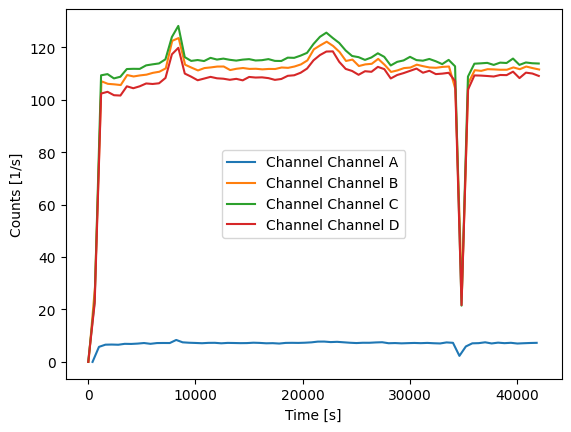

In [6]:
for channel_name, channel_data in data.items():
    count_rates, count_rate_bins = prt.get_count_rate(channel_data["timestamps"], bin_time=600)
    plt.plot(count_rate_bins[:-1], count_rates, label=f"Channel {channel_name}")

plt.xlabel("Time [s]")
plt.ylabel("Counts [1/s]")
plt.legend()
plt.show()

## Plotting coincidences.

The separate channels show energy deposited in an individual diamond by a given coincidence event, and the combined plot shows the total energy of a coincidence event found by summing the energy deposited in each diamond by the particle

In [7]:
# Only the coincidence window (in seconds) and the coincidence_criteria needs to be changed. Everythign else is automatically done
# coincidence_window in seconds (1e-9 = 1 ns)
# coincidence_citeria:
#      0: Ignore thsi channel for the calculation
#      1: use this channel for coincidence caluclations
#      2: Use this channel for anti-coincidence (no count in the time window for this channel is allowed)
# -> structure [Channel A, Channel B, Channel C, Channel D]


df = prt.calculate_coincidence(
    A_time=data["Channel A"]["timestamps"],
    A_ampl=data["Channel A"]["amplitudes"],
    B_time=data["Channel B"]["timestamps"],
    B_ampl=data["Channel B"]["amplitudes"],
    C_time=data["Channel C"]["timestamps"],
    C_ampl=data["Channel C"]["amplitudes"],
    D_time=data["Channel D"]["timestamps"],
    D_ampl=data["Channel D"]["amplitudes"],
    coincidence_window=100e-9,  # 100 ns
    coincidence_citeria=[1, 1, 1, 0],
)

Ignore: 1, Coincidence: 3, Anti-Coincidence: 0
Coincidence between A, B and C


In [8]:
df.head()

,A_time [s],A_amplitude [mV],B_time [s],B_amplitude [mV],C_time [s],C_amplitude [mV],Sum_amplitude [mV]
0,1073.983941,43.062894,1073.983941,39.142987,1073.983941,30.136740,112.342620
1,1099.970165,72.620856,1099.970165,1383.729992,1099.970165,66.098228,1522.449076
2,1102.823226,31.596443,1102.823226,53.376800,1102.823226,97.754468,182.727710
3,1106.815829,47.139854,1106.815829,156.571946,1106.815829,72.429476,276.141276
4,1107.332351,32.360873,1107.332351,45.751543,1107.332351,47.357734,125.470150


In [9]:
print(f"Found {len(df)} coincidence events")

Found 6418 coincidence events


Channel D is not included because it was not used to calculate coincidences (14 MeV neutrons do not reach channel D)

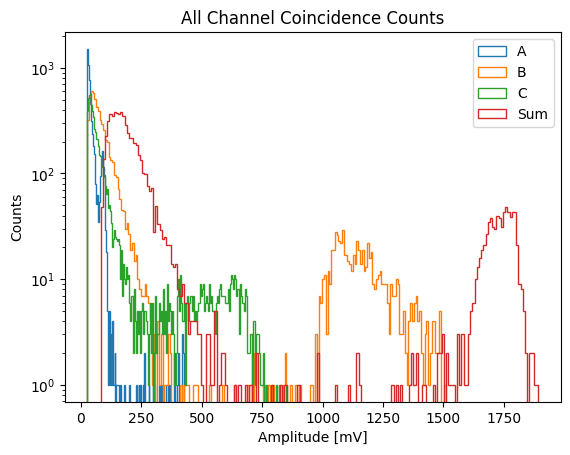

In [10]:
for label in ["A", "B", "C", "Sum"]:

    plt.hist(
        df[f"{label}_amplitude [mV]"],
        bins=200,
        histtype="step",
        label=f"{label}",
    )

plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
plt.title("All Channel Coincidence Counts")
plt.yscale("log")
plt.legend()
plt.show()